In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

file_path = 'terrausd-wormhole-historical-day-data-all-tokeninsight (1).csv'
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'], utc=True)

data.sort_values(by='Date', inplace=True)

data['Price_change_pct'] = data['Price'].pct_change() * 100

depeg_dates = data[(data['Price_change_pct'] > 10) | (data['Price_change_pct'] < -10)]

depeg_table = pd.DataFrame({
    'Date': depeg_dates['Date'],
    'Previous_day_price': data['Price'].shift(1)[depeg_dates.index],
    'Current_day_price': depeg_dates['Price']
}).dropna()

major_depeg_date = depeg_dates.loc[depeg_dates['Price_change_pct'].idxmin()]

depeg_table, major_depeg_date[['Date', 'Price_change_pct']]


(                         Date  Previous_day_price  Current_day_price
 743 2022-05-10 00:00:00+00:00            0.994165           0.811663
 740 2022-05-13 00:00:00+00:00            0.814592           0.544668
 739 2022-05-14 00:00:00+00:00            0.544668           0.122647
 738 2022-05-15 00:00:00+00:00            0.122647           0.183665
 737 2022-05-16 00:00:00+00:00            0.183665           0.150959
 ..                        ...                 ...                ...
 40  2024-04-12 00:00:00+00:00            0.025725           0.020177
 39  2024-04-13 00:00:00+00:00            0.020177           0.016059
 32  2024-04-20 00:00:00+00:00            0.017541           0.020448
 22  2024-04-30 00:00:00+00:00            0.018802           0.012187
 21  2024-05-01 00:00:00+00:00            0.012187           0.017881
 
 [93 rows x 3 columns],
 Date                2022-05-14 00:00:00+00:00
 Price_change_pct                   -77.482231
 Name: 739, dtype: object)

In [2]:
data.sort_values(by='Date', inplace=True)

data['Price_change_pct'] = data['Price'].pct_change() * 100

depeg_dates = data[(data['Price'].shift(1) >= 0.9) & (data['Price'].shift(1) <= 1.1) & (data['Price_change_pct'] < -10)]

depeg_table = pd.DataFrame({
    'Date': depeg_dates['Date'],
    'Previous_day_price': data['Price'].shift(1)[depeg_dates.index],
    'Current_day_price': depeg_dates['Price']
}).dropna()

depeg_table

,Date,Previous_day_price,Current_day_price
743,2022-05-10 00:00:00+00:00,0.994165,0.811663


  # Neutrino 

In [3]:
file_path_new = 'neutrino-usd-historical-day-data-all-tokeninsight.csv'
data_new = pd.read_csv(file_path_new)

data_new['Date'] = pd.to_datetime(data_new['Date'])

lower_bound = 1 * 0.95
upper_bound = 1 * 1.05

lost_peg_new = data_new[(data_new['Price'] < lower_bound) | (data_new['Price'] > upper_bound)].copy()

total_peg_losses_new = lost_peg_new.shape[0]

lost_peg_new.loc[:, 'Diff'] = lost_peg_new['Date'].diff().dt.days.fillna(1)
lost_peg_new.loc[:, 'Event'] = (lost_peg_new['Diff'] > 1).cumsum()
peg_loss_events_new = lost_peg_new.groupby('Event').agg({'Date': ['min', 'max'], 'Price': ['min', 'max']})
peg_loss_events_new.columns = ['Start Date', 'End Date', 'Min Price', 'Max Price']
peg_loss_events_new['Duration (days)'] = (peg_loss_events_new['End Date'] - peg_loss_events_new['Start Date']).dt.days + 1

print(peg_loss_events_new)

total_events_new = peg_loss_events_new.shape[0]
average_duration_new = peg_loss_events_new['Duration (days)'].mean()
min_duration_new = peg_loss_events_new['Duration (days)'].min()
max_duration_new = peg_loss_events_new['Duration (days)'].max()
average_min_price_new = peg_loss_events_new['Min Price'].mean()
average_max_price_new = peg_loss_events_new['Max Price'].mean()

peg_loss_summary_new = {
    'Total Peg Losses': total_peg_losses_new,
    'Total Peg Loss Events': total_events_new,
    'Average Event Duration (days)': average_duration_new,
    'Minimum Event Duration (days)': min_duration_new,
    'Maximum Event Duration (days)': max_duration_new,
    'Average Minimum Price During Events': average_min_price_new,
    'Average Maximum Price During Events': average_max_price_new
}

print(peg_loss_summary_new)

                     Start Date                  End Date  Min Price  \
Event                                                                  
0     2021-05-20 00:00:00+00:00 2024-06-18 00:00:00+00:00   0.012371   

       Max Price  Duration (days)  
Event                              
0         1.3172             1126  
{'Total Peg Losses': 619, 'Total Peg Loss Events': 1, 'Average Event Duration (days)': 1126.0, 'Minimum Event Duration (days)': 1126, 'Maximum Event Duration (days)': 1126, 'Average Minimum Price During Events': 0.0123709, 'Average Maximum Price During Events': 1.3172003}


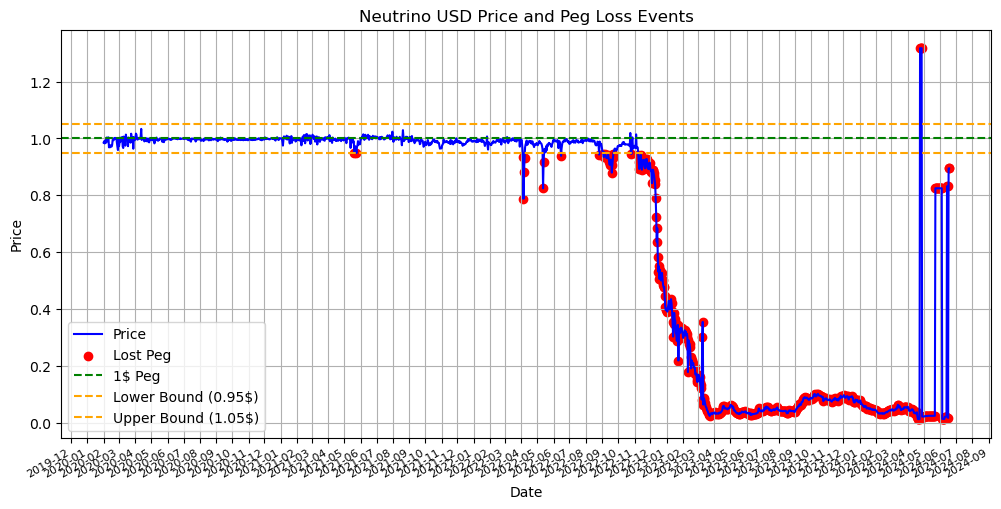

In [4]:
plt.figure(figsize=(12, 6))

plt.plot(data_new['Date'], data_new['Price'], label='Price', color='blue')

plt.scatter(lost_peg_new['Date'], lost_peg_new['Price'], color='red', label='Lost Peg')

plt.axhline(1, color='green', linestyle='--', label='1$ Peg')
plt.axhline(lower_bound, color='orange', linestyle='--', label='Lower Bound (0.95$)')
plt.axhline(upper_bound, color='orange', linestyle='--', label='Upper Bound (1.05$)')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate()
plt.xticks(fontsize=8)  

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Neutrino USD Price and Peg Loss Events')
plt.legend()
plt.grid(True)
plt.show()

# Tether

In [5]:
file_path_tether = 'tether-historical-day-data-all-tokeninsight.csv'
data_tether = pd.read_csv(file_path_tether)

data_tether['Date'] = pd.to_datetime(data_tether['Date'])

lower_bound = 1 * 0.95
upper_bound = 1 * 1.05

lost_peg_tether = data_tether[(data_tether['Price'] < lower_bound) | (data_tether['Price'] > upper_bound)].copy()

total_peg_losses_tether = lost_peg_tether.shape[0]

lost_peg_tether.loc[:, 'Diff'] = lost_peg_tether['Date'].diff().dt.days.fillna(1)
lost_peg_tether.loc[:, 'Event'] = (lost_peg_tether['Diff'] > 1).cumsum()
peg_loss_events_tether = lost_peg_tether.groupby('Event').agg({'Date': ['min', 'max'], 'Price': ['min', 'max']})
peg_loss_events_tether.columns = ['Start Date', 'End Date', 'Min Price', 'Max Price']
peg_loss_events_tether['Duration (days)'] = (peg_loss_events_tether['End Date'] - peg_loss_events_tether['Start Date']).dt.days + 1

print(peg_loss_events_tether)

total_events_tether = peg_loss_events_tether.shape[0]
average_duration_tether = peg_loss_events_tether['Duration (days)'].mean()
min_duration_tether = peg_loss_events_tether['Duration (days)'].min()
max_duration_tether = peg_loss_events_tether['Duration (days)'].max()
average_min_price_tether = peg_loss_events_tether['Min Price'].mean()
average_max_price_tether = peg_loss_events_tether['Max Price'].mean()

peg_loss_summary_tether = {
    'Total Peg Losses': total_peg_losses_tether,
    'Total Peg Loss Events': total_events_tether,
    'Average Event Duration (days)': average_duration_tether,
    'Minimum Event Duration (days)': min_duration_tether,
    'Maximum Event Duration (days)': max_duration_tether,
    'Average Minimum Price During Events': average_min_price_tether,
    'Average Maximum Price During Events': average_max_price_tether
}

print(peg_loss_summary_tether)


                     Start Date                  End Date  Min Price  \
Event                                                                  
0     2015-02-25 00:00:00+00:00 2018-08-09 00:00:00+00:00   0.572521   

       Max Price  Duration (days)  
Event                              
0       1.323095             1262  
{'Total Peg Losses': 32, 'Total Peg Loss Events': 1, 'Average Event Duration (days)': 1262.0, 'Minimum Event Duration (days)': 1262, 'Maximum Event Duration (days)': 1262, 'Average Minimum Price During Events': 0.572521, 'Average Maximum Price During Events': 1.32309531}


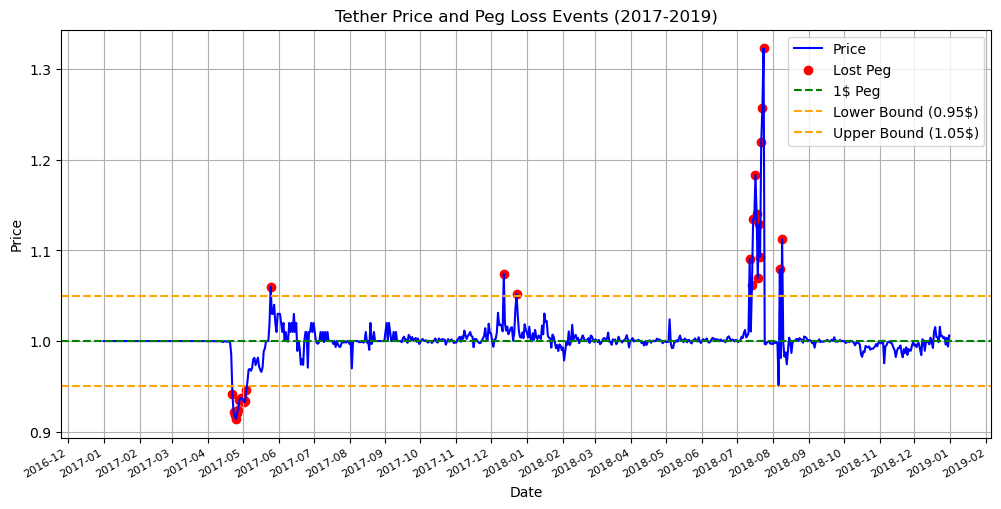

In [6]:
# Since there were no depeges earlier or later than the dates presented, we only presented 
# the ranges of the dates where the depeges happened and not all the timeframe of the dataset
data_tether['Date'] = pd.to_datetime(data_tether['Date'])

lower_bound = 1 * 0.95
upper_bound = 1 * 1.05

data_tether_filtered = data_tether[(data_tether['Date'] >= '2017-01-01') & (data_tether['Date'] <= '2018-12-31')]

lost_peg_tether_filtered = data_tether_filtered[(data_tether_filtered['Price'] < lower_bound) | (data_tether_filtered['Price'] > upper_bound)].copy()

plt.figure(figsize=(12, 6))

plt.plot(data_tether_filtered['Date'], data_tether_filtered['Price'], label='Price', color='blue')

plt.scatter(lost_peg_tether_filtered['Date'], lost_peg_tether_filtered['Price'], color='red', label='Lost Peg')

plt.axhline(1, color='green', linestyle='--', label='1$ Peg')
plt.axhline(lower_bound, color='orange', linestyle='--', label='Lower Bound (0.95$)')
plt.axhline(upper_bound, color='orange', linestyle='--', label='Upper Bound (1.05$)')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate()
plt.xticks(fontsize=8)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tether Price and Peg Loss Events (2017-2019)')
plt.legend()
plt.grid(True)
plt.show()

# Iron

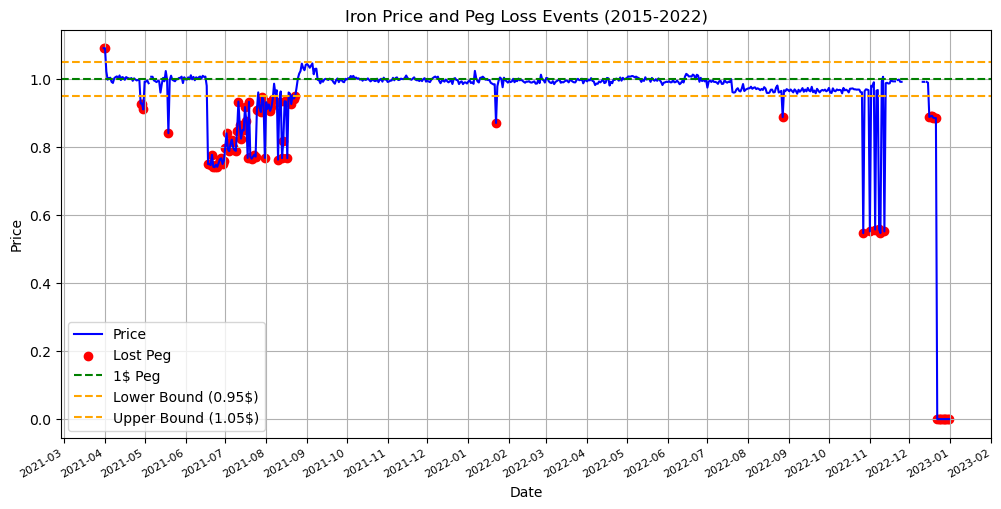

In [7]:
# Load the iron dataset
file_path_iron = 'iron-historical-day-data-all-tokeninsight.csv'
data_iron = pd.read_csv(file_path_iron)

# Convert the Date column to datetime format for easier manipulation
data_iron['Date'] = pd.to_datetime(data_iron['Date'])

# Define the range for the peg (1$ +- 5%)
lower_bound = 1 * 0.95
upper_bound = 1 * 1.05

# Filter the dataset to include only dates from 2015 until 2022
data_iron_filtered = data_iron[(data_iron['Date'] >= '2015-01-01') & (data_iron['Date'] <= '2022-12-31')]

# Find the dates where the token lost its peg (1$ +- 5%) within the filtered date range
lost_peg_iron_filtered = data_iron_filtered[(data_iron_filtered['Price'] < lower_bound) | (data_iron_filtered['Price'] > upper_bound)].copy()

# Plot the price data and highlight the dates where the peg was lost for the iron dataset with smaller font size for x-axis labels
plt.figure(figsize=(12, 6))

# Plot the price
plt.plot(data_iron_filtered['Date'], data_iron_filtered['Price'], label='Price', color='blue')

# Highlight the dates where the peg was lost
plt.scatter(lost_peg_iron_filtered['Date'], lost_peg_iron_filtered['Price'], color='red', label='Lost Peg')

# Add a horizontal line for the 1$ peg and the +-5% bounds
plt.axhline(1, color='green', linestyle='--', label='1$ Peg')
plt.axhline(lower_bound, color='orange', linestyle='--', label='Lower Bound (0.95$)')
plt.axhline(upper_bound, color='orange', linestyle='--', label='Upper Bound (1.05$)')

# Set x-axis major locator to month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate and align the tick labels
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=8)  # Set x-axis font size to smaller

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Iron Price and Peg Loss Events (2015-2022)')
plt.legend()
plt.grid(True)
plt.show()


# Terra

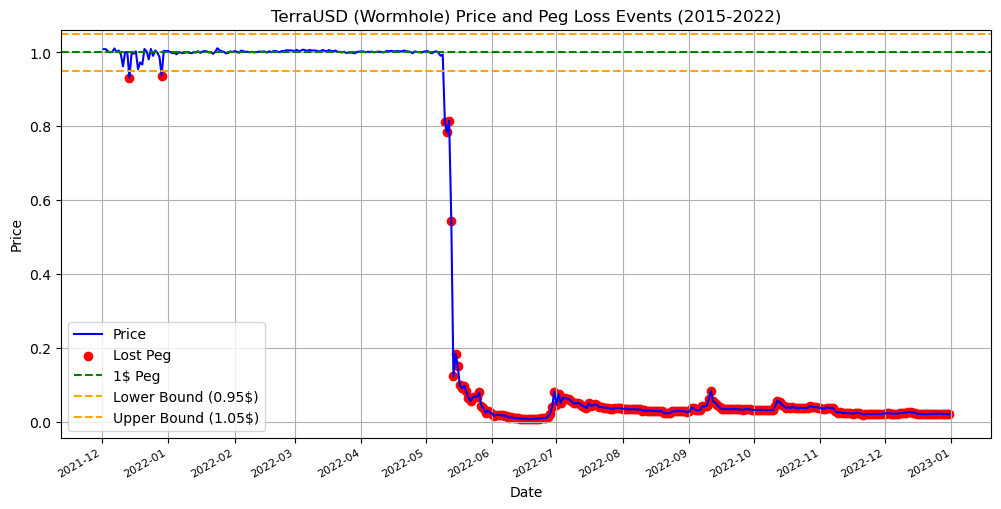

In [8]:
file_path_terrausd = 'terrausd-wormhole-historical-day-data-all-tokeninsight (1).csv'
data_terrausd = pd.read_csv(file_path_terrausd)

# Convert the Date column to datetime format for easier manipulation
data_terrausd['Date'] = pd.to_datetime(data_terrausd['Date'])

# Define the range for the peg (1$ +- 5%)
lower_bound = 1 * 0.95
upper_bound = 1 * 1.05

# Filter the dataset to include only dates from 2015 until 2022
data_terrausd_filtered = data_terrausd[(data_terrausd['Date'] >= '2015-01-01') & (data_terrausd['Date'] <= '2022-12-31')]

# Find the dates where the token lost its peg (1$ +- 5%) within the filtered date range
lost_peg_terrausd_filtered = data_terrausd_filtered[(data_terrausd_filtered['Price'] < lower_bound) | (data_terrausd_filtered['Price'] > upper_bound)].copy()

# Plot the price data and highlight the dates where the peg was lost for the TerraUSD dataset with smaller font size for x-axis labels
plt.figure(figsize=(12, 6))

# Plot the price
plt.plot(data_terrausd_filtered['Date'], data_terrausd_filtered['Price'], label='Price', color='blue')

# Highlight the dates where the peg was lost
plt.scatter(lost_peg_terrausd_filtered['Date'], lost_peg_terrausd_filtered['Price'], color='red', label='Lost Peg')

# Add a horizontal line for the 1$ peg and the +-5% bounds
plt.axhline(1, color='green', linestyle='--', label='1$ Peg')
plt.axhline(lower_bound, color='orange', linestyle='--', label='Lower Bound (0.95$)')
plt.axhline(upper_bound, color='orange', linestyle='--', label='Upper Bound (1.05$)')

# Set x-axis major locator to month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate and align the tick labels
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=8)  # Set x-axis font size to smaller

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TerraUSD (Wormhole) Price and Peg Loss Events (2015-2022)')
plt.legend()
plt.grid(True)
plt.show()


# Correlation

In [9]:
# Load the datasets
neutrino_df = pd.read_csv('neutrino-usd-historical-day-data-all-tokeninsight.csv')
tether_df = pd.read_csv('tether-historical-day-data-all-tokeninsight.csv')
terrausd_df = pd.read_csv('terrausd-wormhole-historical-day-data-all-tokeninsight (1).csv')
iron_df = pd.read_csv('iron-historical-day-data-all-tokeninsight.csv')

# Convert the Date columns to datetime format
neutrino_df['Date'] = pd.to_datetime(neutrino_df['Date'])
tether_df['Date'] = pd.to_datetime(tether_df['Date'])
terrausd_df['Date'] = pd.to_datetime(terrausd_df['Date'])
iron_df['Date'] = pd.to_datetime(iron_df['Date'])

# Merge the dataframes on the Date column
merged_df = pd.merge(neutrino_df[['Date', 'Price']], tether_df[['Date', 'Price']], on='Date', suffixes=('_neutrino', '_tether'))
merged_df = pd.merge(merged_df, terrausd_df[['Date', 'Price']], on='Date')
merged_df = pd.merge(merged_df, iron_df[['Date', 'Price']], on='Date')
merged_df.columns = ['Date', 'Price_neutrino', 'Price_tether', 'Price_terrausd', 'Price_iron']

# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Output the correlation matrix
print(correlation_matrix)

                Price_neutrino  Price_tether  Price_terrausd  Price_iron
Price_neutrino        1.000000      0.102432        0.560579    0.959857
Price_tether          0.102432      1.000000        0.048015    0.073676
Price_terrausd        0.560579      0.048015        1.000000    0.589648
Price_iron            0.959857      0.073676        0.589648    1.000000


/var/folders/tm/b2k_ryfx04v0h21g5q2gklqc0000gn/T/ipykernel_20971/2151699208.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df.corr()


/var/folders/tm/b2k_ryfx04v0h21g5q2gklqc0000gn/T/ipykernel_20971/2949086244.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df.corr()


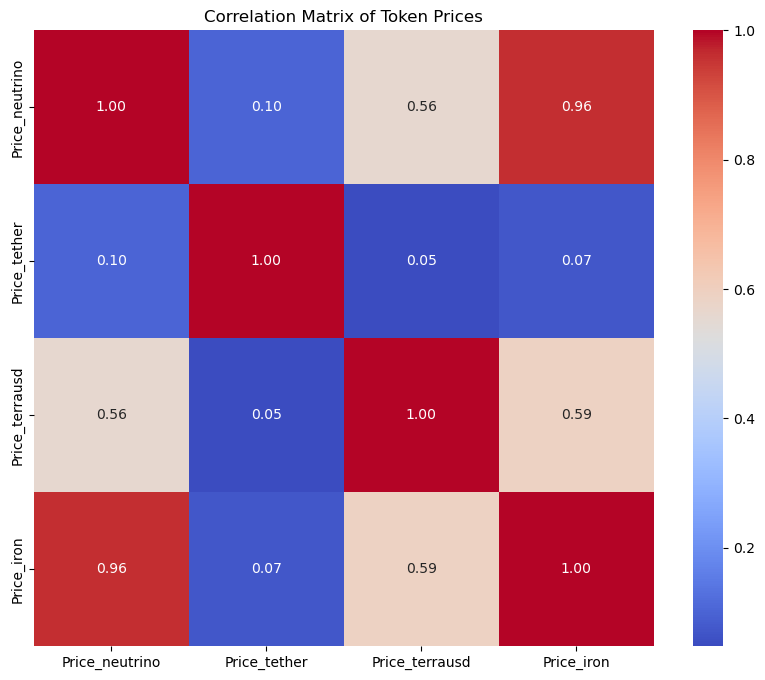

In [10]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Token Prices')
plt.show()

From this analysis there is a high positive correlation between Neutrino USD and Iron as well as a moderate positive correlation between Neutrino USD and TerraUSD. The correlations involving Tether are relatively low, meaning little to no linear relationship with the other tokens. We have used the historical day data for four tokens. Specifically, we focused on the Price column for each token and aligned the data based on their Date.